In [ ]:
from typing import TypedDict, List, Annotated
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image, Markdown
import os
from dotenv import load_dotenv
load_dotenv()

def printmd(string):
    """Helper function to display Markdown content."""
    display(Markdown(string))

os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
llm =  ChatGroq(model="openai/gpt-oss-120b", api_key=GROQ_API_KEY)

c:\Users\ADMIN\OneDrive\Documents\Code\24. Langchain\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class FactCheckState(TypedDict):
    original_text: str
    claims: List[str]
    queries: List[str]
    evidences: str
    fact_check_report: str
    final_text: str

In [3]:
class ClaimsModel(BaseModel):
    claims: Annotated[List[str], Field(description="A list of verifiable factual claims extracted from the text.")]

def extract_claims(state: FactCheckState) -> FactCheckState:
    '''Extracts specific claims and testable statements from text'''
    parser = PydanticOutputParser(pydantic_object=ClaimsModel)
    prompt = PromptTemplate(
        input_variables = ['text'],
        template = '''You are a Senior Fact-Checking Editor for a prestigious news outlet. Your job is to identify every statement in the 
                text: {text} that presents a verifiable factual claim.
            
            # INSTRUCTIONS
            1. Analyze the input text sentence by sentence.
            2. Extract statements that contain:
            - Statistics or numerical data (e.g., "50 percent increase", "2 million people")
            - Specific dates or events (e.g., "On July 4th, 2023...")
            - Assertions of causality (e.g., "Policy X caused Result Y")
            - Quotes attributed to specific people.
            3. Ignore subjective opinions, adjectives, or predictions (e.g., "It was a wonderful performance", "The economy might improve").
            4. Output a list of "Atomic Claims". If a sentence contains multiple facts, split them.
            
            Return the claims as a comma-separated list strictly
            
            {format_instructions}''',
        
        partial_variables = {"format_instructions": parser.get_format_instructions()}
    )

    claim_chain = prompt | llm | parser
    result = claim_chain.invoke({'text': state['original_text']}).claims
    try:
        claims = [claim.strip() for claim in result]
        state['claims'] = claims

        print('Given Text: ', state['original_text'], '\n')
        print('Extracted Claims: \n')
        for claim in claims:
            print("-", claim, '\n')
    except Exception as e:
        print("Error extracting claims: ", e)

    return state

In [4]:
class QueriesModel(BaseModel):
    queries: Annotated[List[str], Field(description="A list of search queries generated from the claims.")]

def generate_queries(state: FactCheckState) -> FactCheckState:
    '''Looks at the extracted claims and writes a search query for them'''
    parser = PydanticOutputParser(pydantic_object=QueriesModel)
    prompt = PromptTemplate(
        input_variables = ['claims'],
        template = '''You are a Search Query Optimizer. Your goal is to convert specific claims into effective search queries that will 
            return the best evidence to verify the claim.
            The claims to convert are: {claims}

            # INSTRUCTIONS
            For each claim provided:
            1. Identify the core entities (Subject, Event, Value).
            2. Remove "fluff" words and complex grammar.
            3. Add time identifiers if the claim refers to a specific period (e.g., "2024", "last year").
            4. Create ONE search query per claim.

            # EXAMPLES
            Claim: "Tesla's stock dropped by 12 percent last Tuesday."
            Query: "Tesla stock price drop percentage last Tuesday date"

            Claim: "The population of Paris is over 10 million."
            Query: "Paris metro area population 2023 official census"

            Return the queries as a comma-separated list strictly
            
            {format_instructions}
            ''',
        partial_variables = {"format_instructions": parser.get_format_instructions()}
    )

    query_chain = prompt | llm | parser
    result = query_chain.invoke({'claims': state['claims']}).queries
    try:
        queries = [query.strip() for query in result]
        state['queries'] = queries
    except Exception as e:
        print("Error generating queries: ", e)

    return state

In [5]:
def search_tool(state: FactCheckState) -> FactCheckState:
    '''Uses Tavily tool to fetch real-time evidence snippets from the web'''
    tavily_tool = TavilySearchResults(max_results=3)
    queries = state['queries']

    if not queries:
        print("No queries to search.")
        return state
    
    prompt = PromptTemplate(
        input_variables = ['query', 'search_results'],
        template = '''You are a Data Scraper Assistant. You have received raw search results that may contain ads, irrelevant navigation links, 
            or duplicate snippets.
            The raw search results for the query are: {search_results}

            # INSTRUCTIONS
            1. Read the raw search results below.
            2. Filter out any content that is clearly an advertisement or unrelated to the query: "{query}".
            3. Extract the most relevant 2-3 sentences that contain specific source name & URLs, numbers, dates, or confirmations of each result
            4. Summarize them into a single "Evidence Snippet".

            '''
    )
    search_chain = prompt | llm

    all_evidence = []

    print("\n\n")
    for query in queries:
        print(f"**Searching for query**: {query}")
        try:
            search_results = tavily_tool.run(query)
            result = search_chain.invoke({'query': query, 'search_results': search_results}).content
            all_evidence.append(result)
        except Exception as e:
            print(f"Error searching for query '{query}': ", e)
            continue

    state['evidences'] = "\n------------\n".join(all_evidence)
    print(f"\n\n**Collected Evidence Snippets:** \n {state['evidences']}")
    return state

In [6]:
class FactReportModel(BaseModel):
    fact_check_report: Annotated[str, Field(description="report summarizing the fact-checking results for the claims based on the evidence provided.")]

def fact_report(state: FactCheckState) -> FactCheckState:
    '''Compares the Original Claims vs. Search Evidence'''
    parser = PydanticOutputParser(pydantic_object=FactReportModel)
    prompt = PromptTemplate(
        input_variables = ['claims', 'evidences'],
        template = '''You are an impartial Fact-Checking Judge. You determine the truthfulness of claims based SOLELY on the provided evidence.

            The list of claims: {claims}

            # INSTRUCTIONS
            For each claim, associate its corresponding search evidences from collection of evidences in {evidences}:
            1. Compare the Claim against the Evidence.
            2. Assign one of the following statuses:
            - "VERIFIED": The evidence explicitly confirms the claim (numbers and dates match).
            - "FALSE": The evidence explicitly contradicts the claim (e.g., Claim says "50%", Evidence says "10%").
            - "INCONCLUSIVE": The evidence is missing, unrelated, or vague.
            3. Provide a one-sentence "Reason" for your verdict.
            4. If "VERIFIED", extract the Source URL or Name from the evidence.
            5. If "FALSE", extract the Correct Information from the evidence.

            Finally compile a comprehensive report summarizing the fact-checking results and your verdicts.
            
            Return the report in string format including following details strictly for each claim:

            "claim": "...",
            "evidence": "...",
            "status": "VERIFIED" | "FALSE" | "INCONCLUSIVE",
            "reason": "...",
            "correction": "..." (only if FALSE),
            "source": "..." (if available)
            
            {format_instructions}
            ''',
        partial_variables = {"format_instructions": parser.get_format_instructions()}
    )
    
    report_chain = prompt | llm | parser
    result = report_chain.invoke({'claims': state['claims'], 'evidences': state['evidences']}).fact_check_report
    try:
        state['fact_check_report'] = result
        print(f"\n\n{state['fact_check_report']}")
    except Exception as e:
        print("Error creating fact-checking report: ", e)
    return state

In [7]:
class DraftModel(BaseModel):
    draft: Annotated[str, Field(description="final rewritten draft correcting original text based on fact-checking report.")]

def rewrite_text(state: FactCheckState) -> FactCheckState:
    '''Rewrites the original text based on verdicts'''
    parser = PydanticOutputParser(pydantic_object=DraftModel)
    prompt = PromptTemplate(
        input_variables = ['original_text','fact_check_report'],
        template = '''You are a Neutral News Editor. Your goal is to rewrite the original text to be objective, accurate, and cited.

            Original Text: {original_text}
            Fact Check Report: {fact_check_report}

            # GUIDELINES
            1. Tone Neutralization: Remove emotionally charged adjectives (e.g., change "disastrous collapse" to "significant decline", 
            "miraculous recovery" to "rapid recovery").
            2. Fact Correction: 
            - If a claim is marked "FALSE" in the Fact Check Report, rewrite the sentence with the *Correct Information*.
            - If a claim is "INCONCLUSIVE", keep it but soften the certainty (e.g., "It is reported that...", "Sources suggest...").
            3. Citation: 
            - If a claim is "VERIFIED", append a citation in brackets at the end of the sentence: `[Source: URL]`.
            4. Flow: Ensure the rewritten text flows naturally. Do not simply list facts.

            Provide the final rewritten article only.

            {format_instructions}
            ''',
        partial_variables = {"format_instructions": parser.get_format_instructions()}
    )
    draft_chain = prompt | llm | parser
    result = draft_chain.invoke({'original_text': state['original_text'], 'fact_check_report': state['fact_check_report']}).draft
    try:
        state['final_text'] = result
        print(f"\n**Final Rewritten Text:** \n{state['final_text']}")
    except Exception as e:
        print("Error generating final rewritten text: ", e)
    
    return state

In [8]:
workflow = StateGraph(FactCheckState)

# Adding nodes to the workflow
workflow.add_node("claim_extraction", extract_claims)
workflow.add_node("query_generation", generate_queries)
workflow.add_node("web_search", search_tool)
workflow.add_node("evidence_cross_reference", fact_report)
workflow.add_node("text_rewriting", rewrite_text)

# Defining edges between nodes
workflow.set_entry_point("claim_extraction")
workflow.add_conditional_edges(
    "claim_extraction", 
    lambda x: 'query_generation' if x['claims'] else 'text_rewriting',
    {                                                    
        "query_generation": "query_generation",
        "text_rewriting": "text_rewriting"
    })
workflow.add_edge("query_generation", "web_search")
workflow.add_edge("web_search", "evidence_cross_reference")
workflow.add_edge("evidence_cross_reference", "text_rewriting")
workflow.add_edge("text_rewriting", END)

app = workflow.compile()

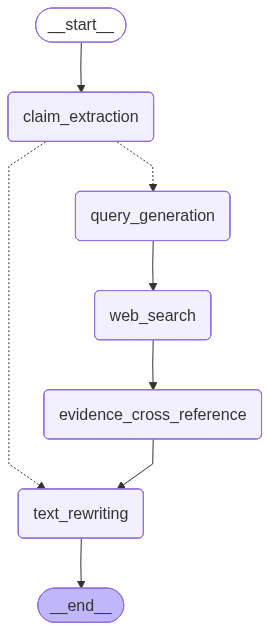

In [9]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [10]:
sample_text = """
Fascinating Facts: From History to Biology
It is a widely accepted fact that the Great Wall of China is the only man-made object 
visible from space with the naked eye. In the animal kingdom, goldfish are known for 
having a memory span of only three seconds. Humans are quite unique as well; 
an adult human skeleton consists of exactly 250 bones, which is more than a baby has. 
On the molecular level, water boils at 100 degrees Fahrenheit at sea level. 
Physics tells us that the speed of light is exactly 299,792,458 meters per second. 
Historically, Napoleon Bonaparte was famously short, standing only 5 feet 2 inches 
in modern measurements, which is why he is often depicted as small.
"""


initial_state = {
    "original_text": sample_text,
    "claims": [],
    "queries": [],           
    "evidences": "",        
    "fact_check_report": "", 
    "final_text": ""        
}

In [11]:
for output in app.stream(initial_state):
    pass 

Given Text:  
Fascinating Facts: From History to Biology
It is a widely accepted fact that the Great Wall of China is the only man-made object 
visible from space with the naked eye. In the animal kingdom, goldfish are known for 
having a memory span of only three seconds. Humans are quite unique as well; 
an adult human skeleton consists of exactly 250 bones, which is more than a baby has. 
On the molecular level, water boils at 100 degrees Fahrenheit at sea level. 
Physics tells us that the speed of light is exactly 299,792,458 meters per second. 
Historically, Napoleon Bonaparte was famously short, standing only 5 feet 2 inches 
in modern measurements, which is why he is often depicted as small.
 

Extracted Claims: 

- The Great Wall of China is the only man-made object visible from space with the naked eye. 

- Goldfish have a memory span of only three seconds. 

- An adult human skeleton consists of exactly 250 bones. 

- An adult human skeleton has more bones than a baby. 

- Wa

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6844\2775228593.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=3)





**Searching for query**: Great Wall of China visible from space naked eye only man-made object evidence
**Searching for query**: goldfish memory span three seconds scientific study
**Searching for query**: adult human skeleton number of bones 250
**Searching for query**: adult versus infant human skeleton bone count comparison
**Searching for query**: water boiling point 100 degrees Fahrenheit sea level
**Searching for query**: speed of light exact value 299,792,458 meters per second
**Searching for query**: Napoleon Bonaparte height 5 feet 2 inches modern measurement
**Searching for query**: Napoleon short stature depiction reason historical analysis


**Collected Evidence Snippets:** 
 **Evidence Snippet**  

- **NASA (wtamu.edu)** – In a 2012 article (https://www.wtamu.edu/~cbaird/sq/2012/12/11/what-makes-the-great-wall-of-china-the-only-man-made-object-visible-from-space/), NASA is cited as stating that *“the Great Wall of China is not visible to the naked eye from space, even i